### Look into distribution of number of classifications made per user for `classify_classifications.csv`:

In [41]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from dateutil.parser import parse
from sf import getFilename, parseTime
from datetime import date
from collections import OrderedDict

%matplotlib inline

In [2]:
font = {
    'family': 'Verdana',
    'weight': '300',
    'size': 12
}

rc('font', **font)

In [3]:
def extract_task_value(task_index, row):
    try:
        return row[task_index]['value']
    except: 
        return
    
def percentageVotesForAnswer(counts, answer):
    '''
    `counts` is a df column like {galaxy: 15, group of objects (cluster): 10, something else/empty center: 2}
    `answer` is one of the keys of counts
    '''
    
    totalVotes = sum(counts.values())
    
    if not answer in counts.keys():
        return 0
    
    votesForAnswer = counts[answer]
    
    return round(100*votesForAnswer/totalVotes, 1)

- ### Extract and parse dataframe:

In [4]:
# load dataframe
df = pd.read_csv('../SpaceFluff/zooniverse_exports/classify-classifications.csv', delimiter=",")

# inspect column names
print(df.keys())

# JSON parse the columns that were stringified
columns_to_parse = ['annotations', 'subject_data', 'metadata']

for column in columns_to_parse:
    df[column] = df[column].apply(json.loads)
    
# extract filename, task0 and task1 values to new dataframe columns
df['Filename'] = df['subject_data'].apply(getFilename)
df['Task0'] = df['annotations'].apply(lambda x: extract_task_value(0, x))
df['Task1'] = df['annotations'].apply(lambda x: extract_task_value(1, x))

# finally, remove all rows where task0 wasn't answered (because the row, then, is useless)
df = df[~df['Task0'].isnull()]

# filter out classifications from beta
df['created_at'] = df['created_at'].apply(parseTime)
end_of_beta = pd.Timestamp(date(2020,10,20), tz='utc')
df = df[df['created_at'] > end_of_beta]
    

Index(['classification_id', 'user_name', 'user_id', 'user_ip', 'workflow_id',
       'workflow_name', 'workflow_version', 'created_at', 'gold_standard',
       'expert', 'metadata', 'annotations', 'subject_data', 'subject_ids'],
      dtype='object')


- ### Look into distribution of votes per user:

In [12]:
users = df['user_name']

print('Unique users by name: {}'.format(users.unique().shape[0]))
print('Unique users by id: {}'.format(df['user_id'].unique().shape[0]))

Unique users by name: 1809
Unique users by id: 1159


@note: Users not logged in don't get assigned an id, so don't use the user_id field for this!

In [15]:
df[df['user_id'].isnull()].head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids,Filename,Task0,Task1
6295,281751667,not-logged-in-48527249623f0fdb25f3,NaN,48527249623f0fdb25f3,16138,Classify!,15.28,2020-10-20 16:57:44+00:00,NaN,NaN,"{'source': 'api', 'session': '73a04e8682324348...","[{'task': 'T0', 'task_label': 'Look at the ver...","{'50757602': {'retired': {'id': 71297616, 'wor...",50757602,UDGcand_388_insp.png,Group of objects (Cluster),None
6296,281751714,not-logged-in-48527249623f0fdb25f3,NaN,48527249623f0fdb25f3,16138,Classify!,15.28,2020-10-20 16:57:52+00:00,NaN,NaN,"{'source': 'api', 'session': '73a04e8682324348...","[{'task': 'T0', 'task_label': 'Look at the ver...","{'50756547': {'retired': {'id': 71296795, 'wor...",50756547,UDGcand_177_insp.png,Group of objects (Cluster),None
6297,281751747,not-logged-in-48527249623f0fdb25f3,NaN,48527249623f0fdb25f3,16138,Classify!,15.28,2020-10-20 16:57:57+00:00,NaN,NaN,"{'source': 'api', 'session': '73a04e8682324348...","[{'task': 'T0', 'task_label': 'Look at the ver...","{'50756678': {'retired': {'id': 71297207, 'wor...",50756678,UDGcand_204_insp.png,Group of objects (Cluster),None
6298,281751772,not-logged-in-48527249623f0fdb25f3,NaN,48527249623f0fdb25f3,16138,Classify!,15.28,2020-10-20 16:58:02+00:00,NaN,NaN,"{'source': 'api', 'session': '73a04e8682324348...","[{'task': 'T0', 'task_label': 'Look at the ver...","{'50755845': {'retired': {'id': 71296844, 'wor...",50755845,UDGcand_44_insp.png,Group of objects (Cluster),None
6299,281751803,not-logged-in-48527249623f0fdb25f3,NaN,48527249623f0fdb25f3,16138,Classify!,15.28,2020-10-20 16:58:07+00:00,NaN,NaN,"{'source': 'api', 'session': '73a04e8682324348...","[{'task': 'T0', 'task_label': 'Look at the ver...","{'50755820': {'retired': {'id': 71297647, 'wor...",50755820,UDGcand_39_insp.png,Group of objects (Cluster),None


In [18]:
groupby_username = df.groupby(['user_name'])

In [52]:
classifications_per_user = np.array([len(classifications) for (user_name, classifications) in groupby_username])

In [56]:
basic_count_stats = {
    'median': np.median(classifications_per_user),
    'mean': np.mean(classifications_per_user),
    'st. dev': np.std(classifications_per_user)
}

basic_count_stats

{'median': 14.0, 'mean': 52.30735212824765, 'st. dev': 175.74535436563824}

In [45]:
unique_classification_counts = set(classifications_per_user)

occurrence = {}
for classification_count in unique_classification_counts:
    occurrence[classification_count] = classifications_per_user.count(classification_count)
    
occurrence = OrderedDict(sorted(occurrence.items()))

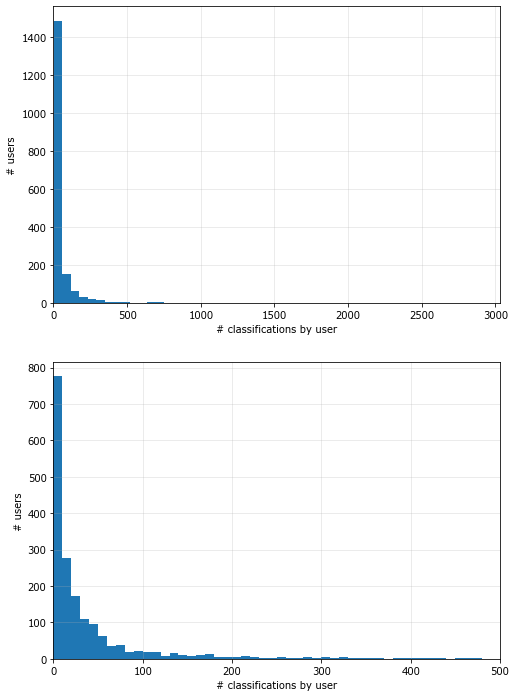

In [119]:
fig, fr = plt.subplots(2,1, figsize=(8,12))

fr[0].hist(classifications_per_user, bins=50)
fr[0].update({
    'xlim': (0),
})

fr[1].hist(classifications_per_user, range=[0,500], bins=50)
fr[1].update({
    'xlim': (0, 500),
    
})

for i in range(2):
    fr[i].grid(which='both', alpha=0.3)
    fr[i].update({
        'xlabel': '# classifications by user',
        'ylabel': '# users'
    })

In [85]:
from pprint import pprint

pprint(occurrence)

OrderedDict([(1, 191),
             (2, 120),
             (3, 107),
             (4, 82),
             (5, 78),
             (6, 62),
             (7, 41),
             (8, 44),
             (9, 51),
             (10, 38),
             (11, 32),
             (12, 28),
             (13, 21),
             (14, 30),
             (15, 31),
             (16, 26),
             (17, 31),
             (18, 20),
             (19, 21),
             (20, 25),
             (21, 25),
             (22, 24),
             (23, 18),
             (24, 16),
             (25, 13),
             (26, 12),
             (27, 14),
             (28, 12),
             (29, 13),
             (30, 13),
             (31, 12),
             (32, 13),
             (33, 11),
             (34, 11),
             (35, 10),
             (36, 14),
             (37, 8),
             (38, 7),
             (39, 9),
             (40, 8),
             (41, 8),
             (42, 12),
             (43, 7),
             (44, 14),


In [102]:
def percentage_votes_below_limit(classifications_per_user, limit):
    return round(100*len(classifications_per_user[classifications_per_user < limit])/len(classifications_per_user), 1)

In [118]:
for limit in [25, 50, 100, 250, 500, 1000]:
    print('% of people with <= {:>4} classifications: {}'.format(limit, percentage_votes_below_limit(classifications_per_user, limit)))

% of people with <=   25 classifications: 64.2
% of people with <=   50 classifications: 79.1
% of people with <=  100 classifications: 88.8
% of people with <=  250 classifications: 96.4
% of people with <=  500 classifications: 98.8
% of people with <= 1000 classifications: 99.5
